In [2]:
# from zipfile import ZipFile
# with ZipFile('/content/gdrive/MyDrive/Dataset.zip', 'r') as zipObj:
#   # Extract all the contents of zip file in current directory
#    zipObj.extractall()

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# !pip install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 7.8 MB/s 


In [4]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [5]:
# size_x,size_y,classes=128,128,2
# num_images = 500

In [6]:
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [7]:
benign_Train="D:\\university\\Dataset\\Dataset\\Breast scans\\benign\\Train\\*.png"
malignant_Train="D:\\university\\Dataset\\Dataset\\Breast scans\\malignant\\Train\\*.png"
benign_Test="D:\\university\\Dataset\\Dataset\\Breast scans\\benign\\Test\\*.png"
malignant_Test="D:\\university\\Dataset\\Dataset\\Breast scans\\malignant\\Test\\*.png"

In [8]:
def check_duplicates(start,end,mask_image):
    i=start
    c=[0]*end
    two_segm=[]
    while i<end+1:
      for image in mask_image:
        if '('+str(i)+')' in image:
          c[i-1]+=1
      i+=1

    for j in range(len(c)):
      if c[j]>1:
          for image in mask_image:
              if '('+str(j+1)+')' in image:
                two_segm.append(image)
          print(j+1," ",end="")
    return two_segm

In [9]:
def merge(image,two_segm):
  if "195" in image:
      ret,thresh =cv2.threshold(cv2.resize(cv2.imread( two_segm[24], 0),(128,128)),55,255,0)
      ret,thresh2 =cv2.threshold(cv2.resize(cv2.imread( two_segm[25], 0),(128,128)),55,255,0)
      ret,thresh3 =cv2.threshold(cv2.resize(cv2.imread( two_segm[26], 0),(128,128)),55,255,0)
      thresh=thresh+thresh2+thresh3
      ret,thresh =cv2.threshold(thresh,55,255,0)
      return thresh

  for i in range (len(two_segm)):
    if two_segm[i]==image:
      ret,thresh =cv2.threshold(cv2.resize(cv2.imread( two_segm[i], 0),(128,128)),55,255,0)
      ret,thresh2 =cv2.threshold(cv2.resize(cv2.imread( two_segm[i+1], 0),(128,128)),55,255,0)
      thresh=thresh+thresh2
      ret,thresh =cv2.threshold(thresh,55,255,0)
      return thresh

In [10]:
def load_images(file_name):
  image_names = glob.glob(file_name)
  mask_image=[]
  image_image=[]
  for image in image_names:
    if "_mask" in image:
        mask_image.append(image)
    else:
      image_image.append(image)

  mask_image.sort()
  image_image.sort()
  two_segm=check_duplicates(1,500,mask_image)
  images = [cv2.resize(cv2.imread(image, 1), (128, 128)) for image in image_image] #SM backbones use 3 channel images, so let us read images in color.
  masks=[]

  for image in mask_image:
    if image not in two_segm:
      ret,thresh =cv2.threshold(cv2.resize(cv2.imread(image, 0),(128,128)),55,255,0)
      masks.append(thresh)

    elif image in two_segm:
      if "mask.png" in image:
        thresh2=merge(image,two_segm)
        masks.append(thresh2)

    
  image_dataset = np.array(images)
  mask_dataset = np.array(masks)
  return image_dataset,mask_dataset


In [11]:
image_dataset_benign,mask_dataset_benign=load_images(benign_Train)
print(len(image_dataset_benign),len(mask_dataset_benign))

4  25  54  58  83  92  93  98  100  163  173  181  195  315  346  397 397


In [12]:
image_dataset_malignant,mask_dataset_malignant=load_images(malignant_Train)
print(len(image_dataset_malignant),len(mask_dataset_malignant))

180 180


In [13]:
image_dataset=np.concatenate((image_dataset_benign, image_dataset_malignant), axis=0)
mask_dataset=np.concatenate((mask_dataset_benign, mask_dataset_malignant), axis=0)

In [14]:
print(len(image_dataset),len(mask_dataset))

577 577


In [15]:
print("Total images in the original dataset are: ", len(image_dataset))
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Total images in the original dataset are:  577
Image data shape is:  (577, 128, 128, 3)
Mask data shape is:  (577, 128, 128)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


In [16]:
# plt.imshow(mask_dataset[222])

In [17]:
# plt.imshow(image_dataset[222])

In [18]:
from sklearn.preprocessing import LabelEncoder
def encode(mask_dataset):
  labelencoder = LabelEncoder()
  n, h, w = mask_dataset.shape  
  mask_dataset_reshaped = mask_dataset.reshape(-1,1)
  mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
  mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)
  print(np.unique(mask_dataset_encoded))
  mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)
  print(mask_dataset_encoded.shape)
  return mask_dataset_encoded


In [19]:
mask_dataset_encoded=encode(mask_dataset)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0 1]
(577, 128, 128, 1)


In [20]:
# image_dataset = image_dataset /255.

In [21]:
#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 1)

In [22]:
import tensorflow
from tensorflow.keras.utils import to_categorical

train_masks_cat = to_categorical(y_train, num_classes=2)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], 2))
test_masks_cat = to_categorical(y_test, num_classes=2)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], 2))
print(y_train_cat.shape)
print(test_masks_cat.shape)


(461, 128, 128, 2)
(116, 128, 128, 2)


In [23]:
#Reused parameters in all models
n_classes=2
activation='softmax'

LR = 0.0005
optim = tensorflow.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [24]:
###Model 
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_processed = preprocess_input(X_train)
X_test_processed = preprocess_input(X_test)
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics=metrics)

print(model.summary())

85521592/85521592 [==============================] - 11s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                          

In [25]:
import time
start=time.time()
history=model.fit(X_train_processed, 
          y_train_cat,
          batch_size=8, 
          epochs=25,
          verbose=1,
          validation_data=(X_test_processed, y_test_cat))
end=time.time()
execution=end-start

Epoch 1/25
58/58 [==============================] - 21s 105ms/step - loss: 0.4480 - iou_score: 0.5509 - f1-score: 0.6627 - val_loss: 0.5609 - val_iou_score: 0.3988 - val_f1-score: 0.5357
Epoch 2/25
58/58 [==============================] - 4s 62ms/step - loss: 0.2461 - iou_score: 0.7159 - f1-score: 0.8102 - val_loss: 0.3722 - val_iou_score: 0.6482 - val_f1-score: 0.7530
Epoch 3/25
58/58 [==============================] - 4s 63ms/step - loss: 0.2201 - iou_score: 0.7256 - f1-score: 0.8191 - val_loss: 0.3576 - val_iou_score: 0.6210 - val_f1-score: 0.7375
Epoch 4/25
58/58 [==============================] - 4s 64ms/step - loss: 0.1996 - iou_score: 0.7466 - f1-score: 0.8343 - val_loss: 0.1912 - val_iou_score: 0.7662 - val_f1-score: 0.8547
Epoch 5/25
58/58 [==============================] - 4s 64ms/step - loss: 0.1667 - iou_score: 0.7798 - f1-score: 0.8612 - val_loss: 0.1751 - val_iou_score: 0.7727 - val_f1-score: 0.8575
Epoch 6/25
58/58 [==============================] - 4s 64ms/step - loss: 

In [26]:
print("Time ",round(execution,1)," seconds")

Time  147.4  seconds


In [ ]:
# model.load_weights('C:\\Users\Sherif Essam\\OneDrive\\Desktop\\segm\\breastweights.h5')

In [27]:
from keras.metrics import MeanIoU
y_pred=model.predict(X_test_processed)
y_pred_argmax=np.argmax(y_pred, axis=3)

4/4 [==============================] - 2s 246ms/step


In [28]:
print(X_test_processed.shape)
print(y_test.shape,y_pred_argmax.shape)

(116, 128, 128, 3)
(116, 128, 128, 1) (116, 128, 128)


In [29]:
def IOU_evaluation(y_test,y_pred):
  n_classes = 2
  IOU_keras = MeanIoU(num_classes=n_classes)  
  IOU_keras.update_state(y_test[:,:,:,0], y_pred)
  print("Mean IoU =", IOU_keras.result().numpy())


In [30]:
IOU_evaluation(y_test,y_pred_argmax)

Mean IoU = 0.7996355


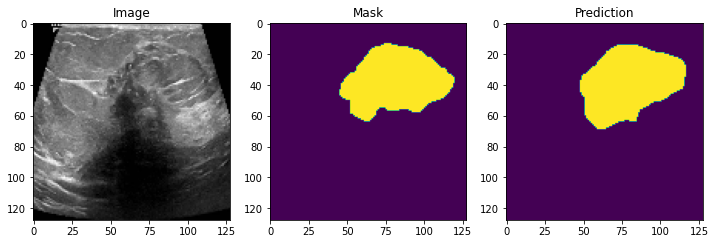

In [31]:
import random
img_number = random.randint(0, len(X_test_processed)-1)
img = X_test_processed[img_number]
mask = y_test[img_number]
prediction = y_pred_argmax[img_number]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Image')
plt.imshow(img, cmap='gray')
plt.subplot(232)
plt.title('Mask')
plt.imshow(mask[:,:,0])
plt.subplot(233)
plt.title('Prediction')
plt.imshow(prediction)
plt.show()

In [32]:
image_dataset_benign,mask_dataset_benign=load_images(benign_Test)
print(len(image_dataset_benign),len(mask_dataset_benign))

424  39 39


In [33]:
image_dataset_malignant,mask_dataset_malignant=load_images(malignant_Test)
print(len(image_dataset_malignant),len(mask_dataset_malignant))

30 30


In [34]:
image_dataset2=np.concatenate((image_dataset_benign, image_dataset_malignant), axis=0)
mask_dataset2=np.concatenate((mask_dataset_benign, mask_dataset_malignant), axis=0)

In [35]:
print(len(image_dataset2))
print(len(mask_dataset2))

69
69


In [36]:
mask_dataset_encoded=encode(mask_dataset2)

[0 1]
(69, 128, 128, 1)


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# image_dataset2 = image_dataset2 /255.

In [37]:
X_processed = preprocess_input(image_dataset2)
X_processed.shape

(69, 128, 128, 3)

In [46]:
start=time.time()
y_pred2=model.predict(X_processed)
y_pred_argmax2=np.argmax(y_pred2, axis=3)
end=time.time()
execution=end-start
print("Time ",round(execution,1)," seconds")

3/3 [==============================] - 0s 53ms/step
Time  0.2  seconds


In [39]:
y_pred_argmax2.shape

(69, 128, 128)

In [40]:
print(mask_dataset_encoded.shape,y_pred_argmax2.shape)


(69, 128, 128, 1) (69, 128, 128)


In [ ]:
IOU_evaluation(mask_dataset_encoded,y_pred_argmax2)

Mean IoU = 0.7470907


(128, 128, 1)


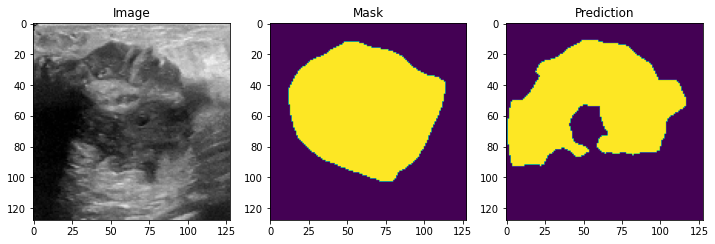

In [43]:

img_number = random.randint(0, len(X_processed)-1)
img = X_processed[img_number]
mask = mask_dataset_encoded[img_number]
prediction = y_pred_argmax2[img_number]
print(mask.shape)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Image')
plt.imshow(img,cmap='gray')
plt.subplot(232)
plt.title('Mask')
plt.imshow(mask[:,:,0])
plt.subplot(233)
plt.title('Prediction')
plt.imshow(prediction)
plt.show()

81 X 115 pixels


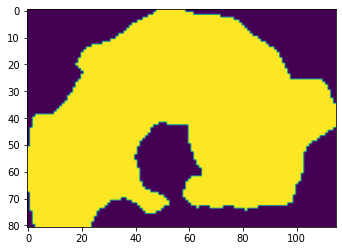

In [44]:
x_min=999
x_max=0
y_min=999
y_max=0
for i in range(len(prediction)):
  for j in range(len(prediction[0])):
    if prediction[i][j]==1:
      if i>y_max:
        y_max=i
      if i<y_min:
        y_min=i
      if j>x_max:
        x_max=j
      if j<x_min:
        x_min=j
# print(x_min,x_max,y_min,y_max)
print(y_max-y_min,'X',x_max-x_min,'pixels')
plt.imshow(prediction[y_min:y_max,x_min:x_max])

In [ ]:
# model.save_weights('breastweights.h5')